##         Lecture 15                    
                                            
Advanced topics with linear regression      
   - Multiple regression                   
   - Model choice with multiple regressors 
   - Prediction with multiple regressors:  
        - useful graphs for predictions     
        - Confidence Interval               
        - Prediction Interval               
    - Robustness tests/External validity    
        - Time/Location/Type                
    - Extra: training and test sample       
                                            
Case Study:                                 
 - Hotels Europe                        
                                            
Dataset used:                               
 - hotel-europe 
 
 ___

Import packages

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

Import Data:\
    now we use all the observations from Europe:

In [2]:
hotels_europe_price = pd.read_csv("https://osf.io/p6tyr/download")
hotels_europe_features = pd.read_csv("https://osf.io/utwjs/download")

Join them by hotel_id

In [3]:
europe = hotels_europe_price.merge(hotels_europe_features, on = "hotel_id")
europe.head()

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,...,country,city_actual,rating_reviewcount,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type
0,1,172,0,0% no offer,2017,11,1,0,1,0,...,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,Amsterdam,4.0,1115.0,3.6,Hotel
1,1,122,1,15-50% offer,2018,1,1,0,1,0,...,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,Amsterdam,4.0,1115.0,3.6,Hotel
2,1,122,1,15-50% offer,2017,12,0,1,1,0,...,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,Amsterdam,4.0,1115.0,3.6,Hotel
3,1,552,1,1-15% offer,2017,12,0,1,4,0,...,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,Amsterdam,4.0,1115.0,3.6,Hotel
4,1,122,1,15-50% offer,2018,2,1,0,1,0,...,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,Amsterdam,4.0,1115.0,3.6,Hotel


In [4]:
del hotels_europe_price
del hotels_europe_features

### I) Predict Hotel prices in Vienna with multiple regressors!

#### A) Data management:

a) get the needed sample:

In [5]:
vienna = (
    europe.loc[lambda x: x["accommodation_type"] == "Hotel"]
    .loc[lambda x: (x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 0)]
    .loc[lambda x: x["city_actual"] == "Vienna"]
    .loc[lambda x: (x["stars"] >= 3) & (x["stars"] <= 4)]
    .loc[lambda x: x["stars"].notnull()]
    .loc[lambda x: x["price"]<=600]
)

 b) calculate log price

In [6]:
vienna["lnprice"] = np.log(vienna["price"])

2) Quick reminder: check the descriptives + association

Summary statistics on price and log of price

In [7]:
(
    vienna.filter(["price", "lnprice", "distance", "stars", "rating"])
    .describe(percentiles=[0.5, 0.95])
    .T
)

,count,mean,std,min,50%,95%,max
price,207.0,109.975845,42.221381,50.000000,100.00000,183.400000,383.000000
lnprice,207.0,4.640219,0.336751,3.912023,4.60517,5.211657,5.948035
distance,207.0,1.529952,1.161507,0.000000,1.30000,3.900000,6.600000
stars,207.0,3.570048,0.478845,3.000000,4.00000,4.000000,4.000000
rating,207.0,4.055556,0.382195,2.200000,4.10000,4.500000,4.800000


Look at the scatter plots - with the visual inspection we can decide which transformation to use!\
p1: distance vs price

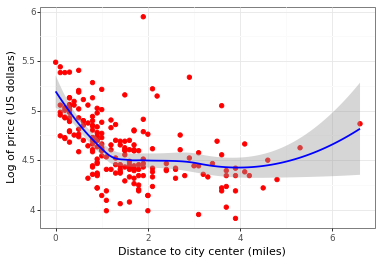

<ggplot: (380535136)>

In [8]:
(
    ggplot(vienna, aes(x="distance", y="lnprice"))
    + geom_point(color="red", size=2)
    + geom_smooth(method="loess", color = "blue")
    + labs(x="Distance to city center (miles)", y="Log of price (US dollars)")
    + theme_bw()
)

 Log for price, Distance: check linear spline with knots at 1 and 4

Stars vs price

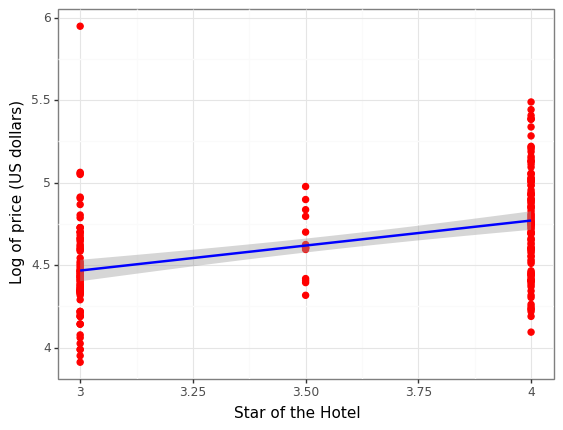

<ggplot: (381295983)>

In [9]:
(
    ggplot(vienna, aes(x="stars", y="lnprice"))
    + geom_point(color="red", size=2)
    + geom_smooth(method="lm", color="blue")
    + labs(x="Star of the Hotel", y="Log of price (US dollars)")
    + theme_bw()
)

Star of a hotel is discrete value: may use as it is, but using it as dummies would make our model more flexible!


### Task: 
plot p3: rating vs price\
    What can you infer?

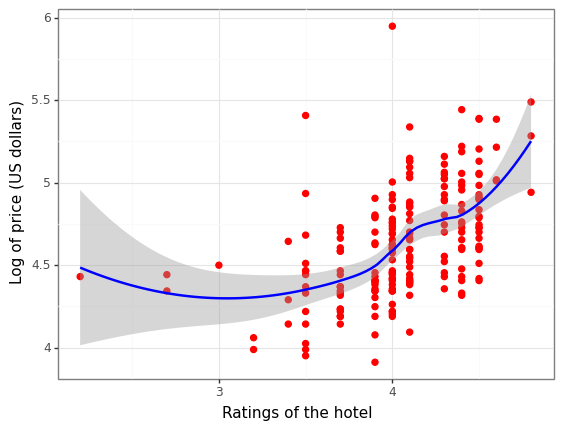

<ggplot: (381344087)>

In [10]:
(
    ggplot(vienna, aes(x="rating", y="lnprice"))
    + geom_point(color="red", size=2)
    + geom_smooth(method="loess", color = "blue")
    + labs(x = "Ratings of the hotel",y = "Log of price (US dollars)")
    + theme_bw()
)

 Rating: check with simple linear and with linear spline around value of 3.5

#### Notes:
  - when the outcome variable is (much) better for log transformation (for most of the variables):
     then you will need to use it in your model, there is nothing to do
  - however if the regressor is needed then it is enough to decide for that particular variable only!

### II) Running regressions:

Baseline A: use only rating with heteroscedastic SE

In [11]:
reg0 = smf.ols("lnprice ~ rating", data=vienna).fit(cov_type ="HC3")
reg0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     41.62
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           7.84e-10
Time:                        19:23:57   Log-Likelihood:                -37.850
No. Observations:                 207   AIC:                             79.70
Df Residuals:                     205   BIC:                             86.37
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8460      0.281     10.112      0.000       2.294       3.398
rating         0.4424      0.069      6.451      0.000       0.308       0.577
==============================================================================
Omnibus:                       28.523   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.031
Skew:                           0.793   Prob(JB):                     4.53e-10
Kurtosis:                       4.572   Cond. No.                         46.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

 Baseline B: use only distance with heteroscedastic SE

In [12]:
reg1 = smf.ols("lnprice ~ distance", data=vienna).fit(cov_type ="HC3")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     28.70
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           2.27e-07
Time:                        19:23:57   Log-Likelihood:                -44.160
No. Observations:                 207   AIC:                             92.32
Df Residuals:                     205   BIC:                             98.99
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8411      0.040    121.283      0.000       4.763       4.919
distance      -0.1313      0.025     -5.357      0.000      -0.179      -0.083
==============================================================================
Omnibus:                       28.470   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.450
Skew:                           0.746   Prob(JB):                     4.97e-11
Kurtosis:                       4.809   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Multiple regression with both rating and distance

In [13]:
reg2 = smf.ols("lnprice ~ distance + rating", data=vienna).fit(cov_type ="HC3")
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     39.03
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           4.44e-15
Time:                        19:23:57   Log-Likelihood:                -20.875
No. Observations:                 207   AIC:                             47.75
Df Residuals:                     204   BIC:                             57.75
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3160      0.282     11.740      0.000       2.762       3.870
distance      -0.1008      0.022     -4.600      0.000      -0.144      -0.058
rating         0.3646      0.066      5.534      0.000       0.235       0.494
==============================================================================
Omnibus:                       48.220   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.776
Skew:                           1.057   Prob(JB):                     8.82e-25
Kurtosis:                       5.893   Cond. No.                         52.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Add the number of stars to out model:\
As stars are discrete values: better to use `dummy` variables instead of one 'quasi-continuous' variable


In [14]:
vienna["star3"] = np.where(vienna["stars"] == 3,1,0)
vienna["star35"] = np.where(vienna["stars"] == 3.5,1,0)
vienna["star4"] = np.where(vienna["stars"] == 4,1,0)

### Task:
Add stars as dummies to the model with heteroscedastic SE\
Discuss what the coefficients mean for star3 and star35! What about star4?

In [15]:
reg3 = smf.ols("lnprice ~ distance + rating + star3 + star35", data=vienna).fit(cov_type ="HC3")
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     24.10
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           2.59e-16
Time:                        19:23:57   Log-Likelihood:                -11.356
No. Observations:                 207   AIC:                             32.71
Df Residuals:                     202   BIC:                             49.38
Df Model:                           4                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6085      0.314     11.504      0.000       2.994       4.223
distance      -0.0909      0.023     -4.001      0.000      -0.135      -0.046
rating         0.3079      0.072      4.281      0.000       0.167       0.449
star3         -0.1679      0.042     -3.952      0.000      -0.251      -0.085
star35        -0.1684      0.057     -2.954      0.003      -0.280      -0.057
==============================================================================
Omnibus:                       65.440   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.207
Skew:                           1.264   Prob(JB):                     5.60e-49
Kurtosis:                       7.401   Cond. No.                         58.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Compare results

In [16]:
table = Stargazer([reg0, reg1, reg2,reg3])
table

More complex models: this is the art of our profession: find the good knot points 
 
 (again this is why we do scatter plots)

Note, Python does not have an `lnspline` function as R, so we wrote one


In [17]:
import copy
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

In [18]:
reg4 = smf.ols(
    "lnprice ~ lspline(distance, [1,4]) + lspline(rating, 3.5) + star3 + star35",
    data=vienna,
).fit(cov_type="HC3")
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     42.56
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           2.51e-36
Time:                        19:23:57   Log-Likelihood:                 14.744
No. Observations:                 207   AIC:                            -13.49
Df Residuals:                     199   BIC:                             13.17
Df Model:                           7                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        5.3047      0.422     12.585      0.000       4.479       6.131
lspline(distance, [1, 4])[0]    -0.4601      0.061     -7.524      0.000      -0.580      -0.340
lspline(distance, [1, 4])[1]    -0.0503      0.021     -2.397      0.017      -0.091      -0.009
lspline(distance, [1, 4])[2]     0.1435      0.051      2.818      0.005       0.044       0.243
lspline(rating, 3.5)[0]         -0.1133      0.122     -0.932      0.351      -0.352       0.125
lspline(rating, 3.5)[1]          0.3599      0.058      6.219      0.000       0.246       0.473
star3                           -0.1496      0.038     -3.900      0.000      -0.225      -0.074
star35                          -0.1322      0.058     -2.276      0.023      -0.246      -0.018
==============================================================================
Omnibus:                      108.185   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              886.011
Skew:                           1.825   Prob(JB):                    4.03e-193
Kurtosis:                      12.455   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [19]:
table = Stargazer([reg2,reg3, reg4])
table

### III) Analyzing the results: our choice is regression 4

Save the predicted and residual values

In [20]:
vienna["lnprice_hat"] = reg4.fittedvalues
vienna["lnprice_resid"] = reg4.resid


Note we are interested in real price values not in logs:\
the first term is straight forward, however the second exp( reg4$ssr /2 ) is a correction term 
  which is needed when dealing with log to exp transformation. Later in DA3 it will be discussed.

In [21]:
corr_term = np.exp(vienna["lnprice_resid"].mean() / 2)
vienna["price_hat"] = np.exp(vienna["lnprice_hat"]) * corr_term

List of 5 best deals

In [22]:
vienna.sort_values(by="lnprice_resid").head(5).filter(
    [
        "hotel_id",
        "price",
        "price_hat",
        "lnprice",
        "lnprice_hat",
        "lnprice_resid",
        "distance",
        "stars",
        "rating",
    ]
)

,hotel_id,price,price_hat,lnprice,lnprice_hat,lnprice_resid,distance,stars,rating
140538,21912,60,105.522617,4.094345,4.658925,-0.564581,1.1,4.0,4.1
141026,21975,115,172.434347,4.744932,5.150017,-0.405084,0.1,4.0,4.3
143630,22344,50,73.448835,3.912023,4.296589,-0.384566,3.9,3.0,3.9
141747,22080,54,75.745847,3.988984,4.327384,-0.338400,1.1,3.0,3.2
142522,22184,75,104.834586,4.317488,4.652384,-0.334896,0.7,3.0,4.1


Why the 5 best lnprice_resid is the same as if we have used price_hat? Discuss!

### Two useful graphs:

 1) y - yhat graph (regression line must be the same as the 45 degree line!)

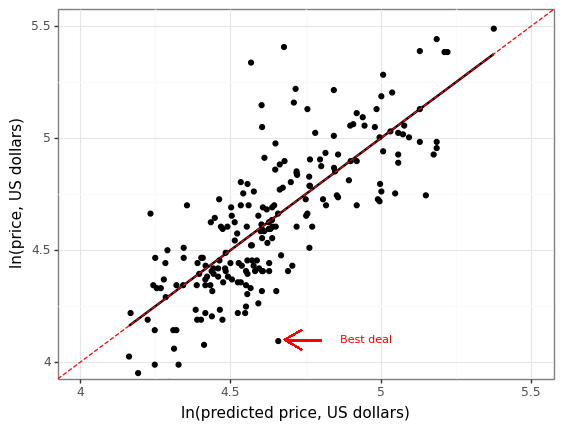

<ggplot: (381771440)>

In [23]:
(
    ggplot(vienna, aes(x="lnprice_hat", y="lnprice"))
    + geom_point()
    + geom_smooth(method="lm", formula="y~x", se=False)
    + labs(x="ln(predicted price, US dollars) ", y="ln(price, US dollars)")
    + geom_segment(
        aes(x=4.8, y=4.1, xend=4.68, yend=4.1),
        arrow=arrow(),
        color="red",
    )
    + annotate("text", x=4.95, y=4.1, label="Best deal", size=8, color="red")
    + geom_abline(intercept=0, slope=1, size=0.5, color="red", linetype="dashed")
    + coord_cartesian(xlim=(4, 5.5), ylim=(4, 5.5))
    + theme_bw()
)

 2) residual - yhat graph: it needs to be flat

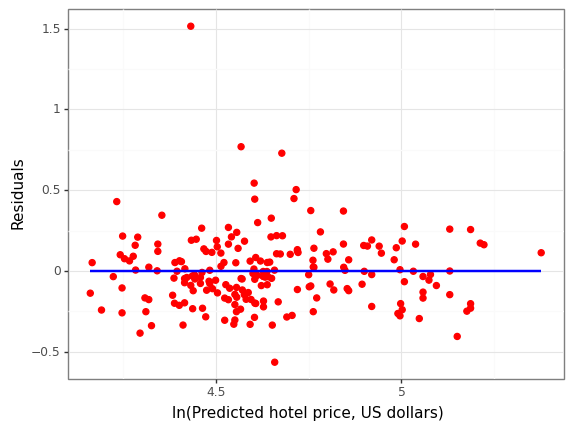

<ggplot: (381758416)>

In [24]:
(
    ggplot(vienna, aes(x="lnprice_hat", y="lnprice_resid"))
    + geom_point(color="red", size=2)
    + geom_smooth(method="lm", colour="blue", se=False, formula="y~x")
    + labs(x="ln(Predicted hotel price, US dollars)", y="Residuals")
    + theme_bw()
)

Helps to evaluate where we tend to make larger errors. It can be used for different regressors!

### Task:

check the graphs across distance! (note it is not always flat, discuss, why!)\
residual - distance graph 

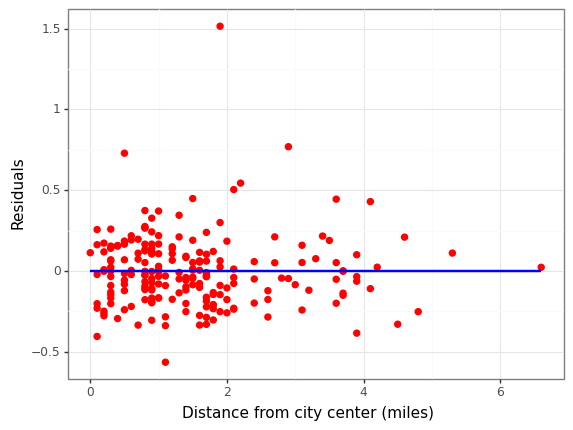

<ggplot: (381758143)>

In [25]:
(
    ggplot(vienna, aes(x="distance", y="lnprice_resid"))
    + geom_point(color="red", size=2)
    + geom_smooth(method="lm", colour="blue", se=False, formula="y~x")
    + labs(x="Distance from city center (miles)", y="Residuals")
    + theme_bw()
)

### Confidence interval for the E(Y|X):
1) predict the outcomes with predict command and use the se.fit = T, \
    this will give you the standard errors for the conditional expectation!


In [26]:
pred_CI = reg4.get_prediction().summary_frame(alpha=0.05)
pred_CI.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
140450,4.556784,0.027994,4.501917,4.611651,4.103015,5.010553
140472,4.499887,0.035351,4.430601,4.569174,4.044150,4.955625
140482,4.443176,0.031090,4.382240,4.504112,3.988633,4.897719
140492,4.581920,0.030218,4.522694,4.641146,4.127603,5.036237
140505,4.637984,0.029996,4.579193,4.696774,4.183724,5.092244


Add the CI values to vienna dataset

In [27]:
vienna["CI_up"] = pred_CI["mean_ci_lower"]
vienna["CI_low"] = pred_CI["mean_ci_upper"]

 Why we usually do not use such graphs, when evaluating multiple regression results:

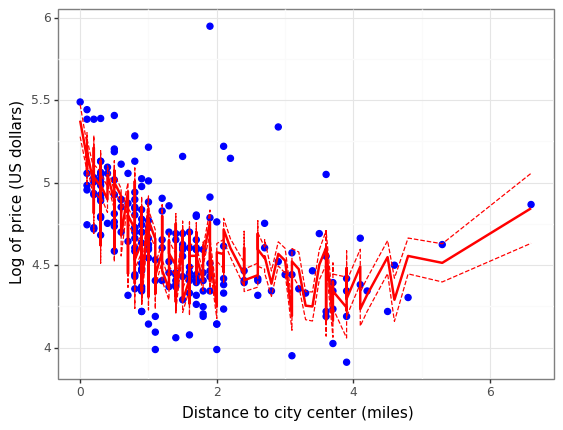

<ggplot: (381876546)>

In [28]:
(
    ggplot(data=vienna)
    + geom_point(aes(x="distance", y="lnprice"), color="blue", size=2)
    + geom_line(aes(x="distance", y="lnprice_hat"), color="red", size=1)
    + geom_line(aes(x="distance", y="CI_up"), color="red", size=0.5, linetype="dashed")
    + geom_line(aes(x="distance", y="CI_low"), color="red", size=0.5, linetype="dashed")
    + labs(x="Distance to city center (miles)", y="Log of price (US dollars)")
    + theme_bw()
)

### Price a new hotel with the model

However you can predict any (new) potential variable

In [29]:
new_hotel_vienna = pd.DataFrame(
    {"distance": 2.5, "star3": 0, "star35": 0, "rating": 3.2}, index=[0]
)

pred_new = reg4.get_prediction(new_hotel_vienna).summary_frame(alpha=0.05)
pred_new

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,4.406601,0.050274,4.308065,4.505137,3.945509,4.867692


Note: you are not really looking for log-price, hence the correction

In [30]:
pred_new["pred_price"] = np.exp(pred_new["mean"])*corr_term
pred_new["CI_low"] = np.exp(pred_new["mean_ci_lower"])*corr_term
pred_new["CI_up"] = np.exp(pred_new["mean_ci_upper"])*corr_term

pred_new.filter(["CI_low","pred_price","CI_up"])

,CI_low,pred_price,CI_up
0,74.296552,81.990274,90.480714


Is the Confidence Interval symmetric? In which case? Why? Discuss! 

### Prediction interval: considers the inherent error as well!

Note: in statsmodels, mean_ci (lower, upper) is CI, and obs_ci (lower, upper) is the prediction interval

In [31]:
pred_new["PI_low"] = np.exp(pred_new["obs_ci_lower"])*corr_term
pred_new["PI_up"] = np.exp(pred_new["obs_ci_upper"])*corr_term

pred_new.filter(["PI_low","pred_price","PI_up"])

,PI_low,pred_price,PI_up
0,51.702656,81.990274,130.020497


 Let us compare the two results for our newly predicted hotel:

In [32]:
pred_new.filter(["pred_price","CI_low","CI_up","PI_low","PI_up"])

,pred_price,CI_low,CI_up,PI_low,PI_up
0,81.990274,74.296552,90.480714,51.702656,130.020497


 Discuss what the results mean! How would you price this hotel?

### Task:

There is a new hotel with the following feature values that you would like to price \

    distance = 0.25 , star3 = 0 , star35 = 0, rating = 4.1
   
- Now, you use polynomials rather than piecewise linear spline up to 3rd order for distance and rating. 
- Use dummies for stars and use heteroskedastic robust SE!
- Estimate the model, and check the distance and ratings against the residuals for the LEVELS.
- Calculate the CI and PI with 80% levels, using the `level` input argument for this hotel based on the model.

What price would you use? Argue!

Model:

In [33]:
reg_poly = smf.ols(
    "lnprice ~ distance + np.power(distance, 2)+ np.power(distance, 3) + rating + np.power(rating, 2)+ np.power(rating, 3)+ star3 + star35",
    data=vienna,
).fit(cov_type="HC3")

Predictions and errors 

1. for log values

In [34]:
vienna["lnprice_hat_rp"] = reg_poly.fittedvalues
vienna["lnprice_resid_rp"] = reg_poly.resid

2.  for the levels

In [35]:
corr_term_rp = np.exp(vienna["lnprice_resid_rp"].mean() / 2)
vienna["price_hat_rp"] = np.exp(vienna["lnprice_hat_rp"]) * corr_term_rp
vienna["price_resid_rp"] = vienna["price"] - vienna["price_hat_rp"]

Create a residual vs distance graph

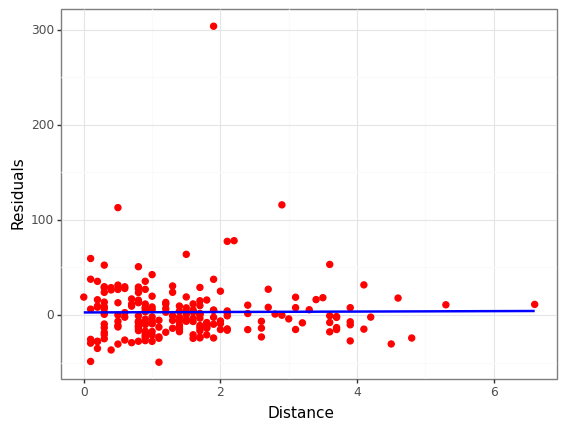

<ggplot: (381958349)>

In [36]:
(
    ggplot(vienna, aes(x="distance", y="price_resid_rp"))
    + geom_point(color="red", size=2)
    + geom_smooth(method="lm", colour="blue", se=False, formula="y~x")
    + labs(x="Distance", y="Residuals")
    + theme_bw()
)

Create a residual vs ratings graph 

-> model makes large errors around 4,   in both directions, but mainly underprice the hotels. Not too serious.

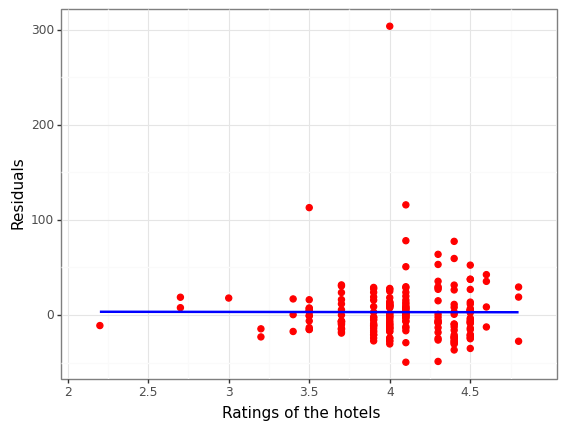

<ggplot: (381991504)>

In [37]:
(
    ggplot(vienna, aes(x="rating", y="price_resid_rp"))
    + geom_point(color="red", size=2)
    + geom_smooth(method="lm", colour="blue", se=False, formula="y~x")
    + labs(x="Ratings of the hotels", y="Residuals")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(2, 5), breaks=np.arange(2, 5, 0.5)
    )
    + theme_bw()
)

#### CI and PI for the new hotel

In [38]:
new_hotel2_vienna = pd.DataFrame(
    {"distance": 0.25, "star3": 0, "star35": 0, "rating": 4.1}, index=[0]
)

pred_new2 = reg_poly.get_prediction(new_hotel2_vienna).summary_frame(alpha=0.2)
pred_new2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,4.955415,0.036862,4.908175,5.002656,4.65345,5.257381


In [39]:
pred_new2["pred_price"] = np.exp(pred_new2["mean"])*corr_term_rp
pred_new2["CI_low"] = np.exp(pred_new2["mean_ci_lower"])*corr_term_rp
pred_new2["CI_up"] = np.exp(pred_new2["mean_ci_upper"])*corr_term_rp
pred_new2["PI_low"] = np.exp(pred_new2["obs_ci_lower"])*corr_term_rp
pred_new2["PI_up"] = np.exp(pred_new2["obs_ci_upper"])*corr_term_rp
pred_new2.filter(["pred_price","CI_low","CI_up","PI_low","PI_up"]).round(2)

,pred_price,CI_low,CI_up,PI_low,PI_up
0,141.94,135.39,148.81,104.95,191.98


As the model probably underprice this hotel around this distance rating, \
  I would use a larger price than predicted. However, this is a new hotel, \
  thus start with a lower price make some good word-of-mouth can be beneficial.\
 In sum something around the CI_high can be a good point if there are no other reasons.

## IV) External validity of the model


 We want to test how our favorite model would perform if we change:\
 time OR place OR type of observations (e.g. Apartment instead of Hotels)

0) Add the variable transformations to the general dataset: hotels-europe

In [40]:
europe["lnprice"] = np.log(europe["price"])
europe["star3"] = np.where(europe["stars"] == 3, 1, 0)
europe["star35"] = np.where(europe["stars"] == 3.5, 1, 0)

 ### 1) First let check for different time: Vienna multiple time

In [41]:
vienna_m_time = (
    europe.loc[lambda x: x["accommodation_type"] == "Hotel"]
    .loc[lambda x: x["city_actual"] == "Vienna"]
    .loc[lambda x: x["nnights"] == 1]
    .loc[lambda x: (x["stars"] >= 3) & (x["stars"] <= 4)]
    .loc[lambda x: x["stars"].notnull()]
    .loc[lambda x: x["price"] <= 600]
)

IMPORTANT: for a fair comparison, we need to use the SAME HOTELS!\
we have three alternative candidates:
    
    main: 2017/11 weekday
    1): 2017/11 on a weekend
    2): 2017 December, holiday
    3): 2018 June, weekend

first we get our preferred dates

In [42]:
vienna_m_time = vienna_m_time.loc[
    lambda x: ((x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 0))
    | ((x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 1))
    | ((x["year"] == 2017) & (x["month"] == 12) & (x["holiday"] == 1))
    | ((x["year"] == 2018) & (x["month"] == 6) & (x["weekend"] == 1))
]

Secondly we extract the frequencies for each hotels

In [43]:
vienna_m_time["hotel_id"].value_counts()

21897    4
22190    4
22169    4
22176    4
21901    4
        ..
21982    1
22019    1
22042    1
22407    1
22262    1
Name: hotel_id, Length: 218, dtype: int64

Hotels with frequency of four are in all of our dates

In [44]:
four_freq_id = vienna_m_time["hotel_id"].value_counts().loc[lambda x: x == 4].index

vienna_m_time = vienna_m_time.loc[lambda x: x["hotel_id"].isin(four_freq_id)]

Save the formula for the main model:

In [45]:
m_form = "lnprice ~ lspline(distance, [1,4]) + lspline(rating, 3.5) + star3 + star35"

Our main model: 2017/11 in a weekday

In [46]:
regt_0 = smf.ols(
    m_form,
    data=vienna_m_time.loc[
        lambda x: ((x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 0))
    ],
).fit(cov_type="HC3")

 Alternatively 1) 2017/11 on a weekend

In [47]:
regt_1 = smf.ols(
    m_form,
    data=vienna_m_time.loc[
        lambda x: ((x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 1))
    ],
).fit(cov_type="HC3")

Alternatively 2) 2017 December, holiday

In [48]:
regt_2 = smf.ols(
    m_form,
    data=vienna_m_time.loc[
        lambda x: ((x["year"] == 2017) & (x["month"] == 12) & (x["holiday"] == 1))
    ],
).fit(cov_type="HC3")

Alternatively 2) 2018 June, weekend

In [49]:
regt_3 = smf.ols(
    m_form,
    data=vienna_m_time.loc[
        lambda x: ((x["year"] == 2018) & (x["month"] == 6) & (x["weekend"] == 1))
    ],
).fit(cov_type="HC3")

Compare the results:

In [50]:
table = Stargazer([regt_0, regt_1, regt_2, regt_3])
table.custom_columns(
    [
        "2017/11 weekday",
        "2017/11 on a weekend",
        "2017 December, holiday",
        "2018 June, weekend",
    ],
    [1, 1, 1, 1],
)
table

With prediction look at: R2, and stability of the parameters!

### 2) Second let's check for different accommodation types in Vienna:

Compare hotels with Apartments:

Note: we only change one thing at a time!

In [51]:
vienna_h_vs_a = (
    europe.loc[
        lambda x: (x["accommodation_type"] == "Hotel")
        | (x["accommodation_type"] == "Apartment")
    ]
    .loc[lambda x: (x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 1)]
    .loc[lambda x: x["city_actual"] == "Vienna"]
    .loc[lambda x: x["nnights"] == 1]
    .loc[lambda x: (x["stars"] >= 3) & (x["stars"] <= 4)]
    .loc[lambda x: x["stars"].notnull()]
    .loc[lambda x: x["price"] <= 600]
    .loc[lambda x: x["rating"].notnull()]
)

Note: here we can not compare the same observations as they are inherently different

Run regression for the hotels

In [52]:
regh = smf.ols(
    m_form, data=vienna_h_vs_a.loc[lambda x: x["accommodation_type"] == "Hotel"]
).fit(cov_type="HC3")

Run regression for the apartments

In [53]:
rega = smf.ols(
    m_form, data=vienna_h_vs_a.loc[lambda x: x["accommodation_type"] == "Apartment"]
).fit(cov_type="HC3")

In [54]:
table = Stargazer([regh, rega])
table.custom_columns(["Hotels", "Apartments"], [1, 1])
table

 ### Task: 
    
   3) Compare different cities:

Check Vienna, Amsterdam, and Barcelona!


Note: Get rid of the price filter!


In [55]:
hotels_cities = (
    europe.loc[lambda x: x["accommodation_type"] == "Hotel"]
    .loc[lambda x: (x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 1)]
    .loc[
        lambda x: (x["city_actual"] == "Vienna")
        | (x["city_actual"] == "Amsterdam")
        | (x["city_actual"] == "Barcelona")
    ]
    .loc[lambda x: x["nnights"] == 1]
    .loc[lambda x: (x["stars"] >= 3) & (x["stars"] <= 4)]
    .loc[lambda x: x["stars"].notnull()]
    .loc[lambda x: x["rating"].notnull()]
)

Run regression for Vienna

In [56]:
reg_v = smf.ols(
    m_form, data=hotels_cities.loc[lambda x: x["city_actual"] == "Vienna"]
).fit(cov_type="HC3")

Run regression for Amsterdam

In [57]:
reg_a = smf.ols(
    m_form, data=hotels_cities.loc[lambda x: x["city_actual"] == "Amsterdam"]
).fit(cov_type="HC3")

Run regression for Barcelona

In [58]:
reg_b = smf.ols(
    m_form, data=hotels_cities.loc[lambda x: x["city_actual"] == "Barcelona"]
).fit(cov_type="HC3")

In [59]:
table = Stargazer([reg_v, reg_a, reg_b])
table.custom_columns(["Vienna", "Amsterdam", "Barcelona"], [1, 1, 1])
table

### Extra:
 In prediction competitions usually there is a training/available sample\
   and a test/locked sample for the competitors. \
   The task is to build a model which gives the best prediction (according to a pre-defined measure)
   
 E.g. uses our original sample, and create a train-test split using the sklean package

In [60]:
from sklearn.model_selection import train_test_split

vienna_train, vienna_test = train_test_split(vienna, train_size=150, random_state=234)

Let us use two competing models:

model 1: simple multivariate model


In [61]:
pred_m1 = smf.ols(
    "lnprice ~ distance + rating + star3 + star35", data=vienna_train
).fit()

model 2: multivariate model with linear splines

In [62]:
pred_m2 = smf.ols(m_form, data=vienna_train).fit()

Now let us use these models on our test sample to predict the values

In [63]:
pred_compare = pd.DataFrame(
    [
        pred_m1.predict(vienna_test),
        pred_m2.predict(vienna_test),
        vienna_test["lnprice"],
    ],
    index=["m1_lnprice", "m2_lnprice", "actual_lnprice"],
).T

If you want to visualize

In [64]:
pred_compare.shape

(57, 3)

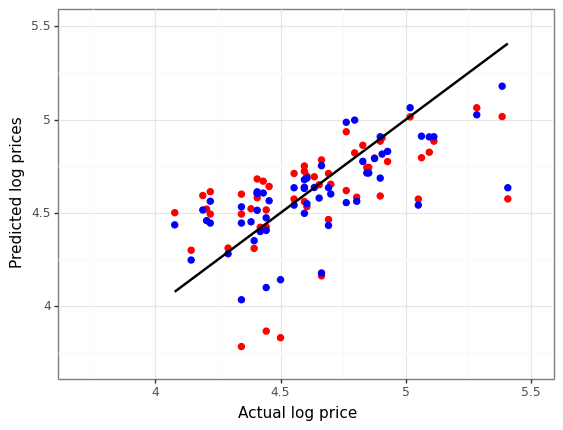

<ggplot: (382079127)>

In [65]:
(
    ggplot(pred_compare)
    + geom_point(aes(x="actual_lnprice", y="m1_lnprice"), color="red", size=2)
    + geom_point(aes(x="actual_lnprice", y="m2_lnprice"), color="blue", size=2)
    + geom_line(aes(x="actual_lnprice", y="actual_lnprice"), color="black", size=1)
    + labs(x="Actual log price", y="Predicted log prices")
    + coord_cartesian(xlim=(3.7, 5.5), ylim=(3.7, 5.5))
    + theme_bw()
)

Evaluate according to RMSE measure:

In [66]:
from sklearn.metrics import mean_squared_error

The two rmse values

In [67]:
mean_squared_error(
    pred_compare["actual_lnprice"], pred_compare["m1_lnprice"], squared=False
)

0.26814010722331905

In [68]:
mean_squared_error(
    pred_compare["actual_lnprice"], pred_compare["m2_lnprice"], squared=False
)

0.2193155433380613

Therefore model 2 wins this competition according to RMSE measure.